In [13]:
import sys
import os
sys.path.append(os.path.abspath("../scripts"))
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import GridSearchCV, TimeSeriesSplit
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import PowerTransformer, QuantileTransformer
from sklearn.feature_selection import mutual_info_classif
from sklearn.ensemble import HistGradientBoostingClassifier
from sklearn.metrics import accuracy_score, f1_score, roc_auc_score, make_scorer, precision_score, recall_score
from statsmodels.stats.outliers_influence import variance_inflation_factor
from model_utils import rolling_test, optimize_threshold
from preprocessing import feature_engineering, analyze_features
from sklearn.neural_network import MLPClassifier
plt.style.use("ggplot")

In [14]:
X = pd.read_csv('../data/X.csv', index_col='date', parse_dates=True)
y = pd.read_csv('../data/y.csv', index_col='date', parse_dates=True)

In [15]:
val_size = 100
X_train, X_test = X.iloc[:-val_size], X.iloc[-val_size:]
y_train, y_test = y.iloc[:-val_size], y.iloc[-val_size:]

In [16]:
mlp = MLPClassifier(random_state=42)

In [17]:
"""
Pipeline composed by:
1. PowerTransformer with 'yeo-johnson' method for handling skew and kurtosis.
2. QuantileTransformer to normalize the distribution of features and stabilize variance for MLP.
"""

pipeline = Pipeline([
    ('power', PowerTransformer('yeo-johnson')),
    ("scaler", QuantileTransformer(output_distribution='normal', random_state=42)),
    ("model", mlp)
])

In [18]:
param_grid = {
    'model__hidden_layer_sizes': [(64, 32)],
    'model__activation': ['relu'],
    'model__solver': ['adam'],
    'model__alpha': [0.005],
    'model__learning_rate_init': [0.005],
    'model__early_stopping': [True],
    'model__max_iter': [500],
    'model__n_iter_no_change': [20],
    'model__batch_size': [16]
}

In [19]:
# TimeSeriesSplit for cross-validation and hyperparameter tuning with grid search.
# F1 score is used as the primary metric for refitting due to unbalanced classes and the interest of capturing positive class performance.
# The parameter set were defined from previous experiments.

tscv = TimeSeriesSplit(n_splits=4)
scoring = {
    'accuracy': 'accuracy',
    'f1': 'f1',
    'roc_auc': 'roc_auc'
}

grid = GridSearchCV(
    estimator=pipeline,
    param_grid=param_grid,
    scoring=scoring,
    refit='f1',
    cv=tscv,
    return_train_score=True,
    verbose=2
)
grid.fit(X_train, y_train)

Fitting 4 folds for each of 1 candidates, totalling 4 fits


c:\Users\santi\anaconda3\Lib\site-packages\sklearn\preprocessing\_data.py:2627: UserWarning: n_quantiles (1000) is greater than the total number of samples (80). n_quantiles is set to n_samples.
  warnings.warn(
c:\Users\santi\anaconda3\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:1098: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] END model__activation=relu, model__alpha=0.005, model__batch_size=16, model__early_stopping=True, model__hidden_layer_sizes=(64, 32), model__learning_rate_init=0.005, model__max_iter=500, model__n_iter_no_change=20, model__solver=adam; total time=   0.1s


c:\Users\santi\anaconda3\Lib\site-packages\sklearn\preprocessing\_data.py:2627: UserWarning: n_quantiles (1000) is greater than the total number of samples (156). n_quantiles is set to n_samples.
  warnings.warn(
c:\Users\santi\anaconda3\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:1098: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] END model__activation=relu, model__alpha=0.005, model__batch_size=16, model__early_stopping=True, model__hidden_layer_sizes=(64, 32), model__learning_rate_init=0.005, model__max_iter=500, model__n_iter_no_change=20, model__solver=adam; total time=   0.1s


c:\Users\santi\anaconda3\Lib\site-packages\sklearn\preprocessing\_data.py:2627: UserWarning: n_quantiles (1000) is greater than the total number of samples (232). n_quantiles is set to n_samples.
  warnings.warn(
c:\Users\santi\anaconda3\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:1098: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] END model__activation=relu, model__alpha=0.005, model__batch_size=16, model__early_stopping=True, model__hidden_layer_sizes=(64, 32), model__learning_rate_init=0.005, model__max_iter=500, model__n_iter_no_change=20, model__solver=adam; total time=   0.2s


c:\Users\santi\anaconda3\Lib\site-packages\sklearn\preprocessing\_data.py:2627: UserWarning: n_quantiles (1000) is greater than the total number of samples (308). n_quantiles is set to n_samples.
  warnings.warn(
c:\Users\santi\anaconda3\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:1098: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] END model__activation=relu, model__alpha=0.005, model__batch_size=16, model__early_stopping=True, model__hidden_layer_sizes=(64, 32), model__learning_rate_init=0.005, model__max_iter=500, model__n_iter_no_change=20, model__solver=adam; total time=   0.3s


c:\Users\santi\anaconda3\Lib\site-packages\sklearn\preprocessing\_data.py:2627: UserWarning: n_quantiles (1000) is greater than the total number of samples (384). n_quantiles is set to n_samples.
  warnings.warn(
c:\Users\santi\anaconda3\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:1098: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


GridSearchCV(cv=TimeSeriesSplit(gap=0, max_train_size=None, n_splits=4, test_size=None),
             estimator=Pipeline(steps=[('power', PowerTransformer()),
                                       ('scaler',
                                        QuantileTransformer(output_distribution='normal',
                                                            random_state=42)),
                                       ('model',
                                        MLPClassifier(random_state=42))]),
             param_grid={'model__activation': ['relu'], 'model__alpha': [0.005],
                         'model__batch_size': [16],
                         'model__early_stopping': [True],
                         'model__hidden_layer_sizes': [(64, 32)],
                         'model__learning_rate_init': [0.005],
                         'model__max_iter': [500],
                         'model__n_iter_no_change': [20],
                         'model__solver': ['adam']},
             refit='f1', return_train_score=True,
             scoring={'accuracy': 'accuracy', 'f1': 'f1', 'roc_auc': 'roc_auc'},
             verbose=2)

In [20]:
print("Best cross f1:", grid.best_score_)

Best cross f1: 0.5810719658821042


In [21]:
# Rolling evaluation: Multiple train-test splits to assess model performance over time, 
# allowing to observe the stability and robustness of the model in diferent market conditions.
results = rolling_test(pipeline, X, y, test_window=50, step=25, min_train_size=250, verbose=True)

c:\Users\santi\anaconda3\Lib\site-packages\sklearn\preprocessing\_data.py:2627: UserWarning: n_quantiles (1000) is greater than the total number of samples (250). n_quantiles is set to n_samples.
  warnings.warn(
c:\Users\santi\anaconda3\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:1098: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
c:\Users\santi\anaconda3\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
c:\Users\santi\anaconda3\Lib\site-packages\sklearn\preprocessing\_data.py:2627: UserWarning: n_quantiles (1000) is greater than the total number of samples (275). n_quantiles is set to n_samples.
  warnings.warn(
c:\Users\santi\anaconda3\Lib\site-packages\sklearn\neur

>>> Rolling Test (threshold 0.5):
Mean Accuracy: 0.5500
Mean F1 Score: 0.5778
Mean ROC AUC Score: 0.5873


c:\Users\santi\anaconda3\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


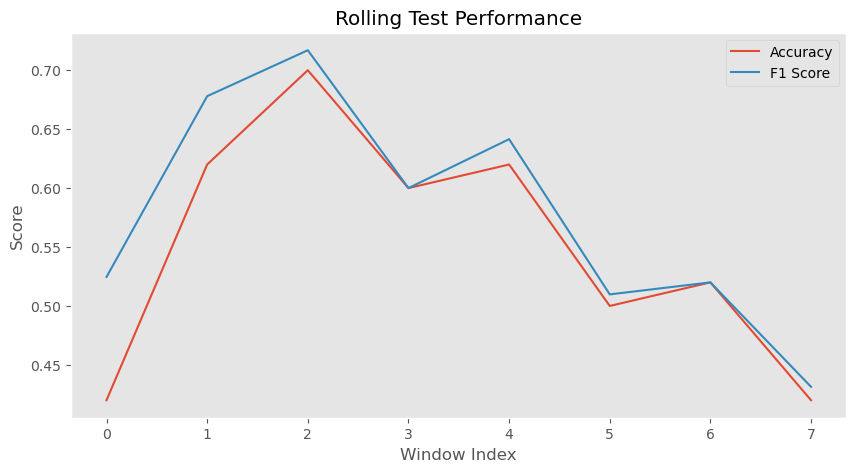

In [22]:
plt.figure(figsize=(10,5))
plt.plot(range(len(results['accuracies'])), results['accuracies'], label='Accuracy')
plt.plot(range(len(results['f1_scores'])), results['f1_scores'], label='F1 Score')
plt.title("Rolling Test Performance")
plt.xlabel("Window Index")
plt.ylabel("Score")
plt.legend()
plt.grid()
plt.savefig("../reports/figures/rolling_test_performance.png")
plt.show()
plt.close()

This chart shows the evolution of Accuracy and F1 Score across multiple time windows in the rolling test.
A good initial performance is observed, with F1 peaks above 0.7, indicating that the model correctly captures price movements in certain periods.
However, from the fourth window onwards, performance drops and stabilizes at lower values (F1 between 0.5 and 0.6), reflecting that the model loses predictive power in some market contexts.
This suggests that performance is sensitive to market conditions and that adaptive strategies or model ensembles could be useful.

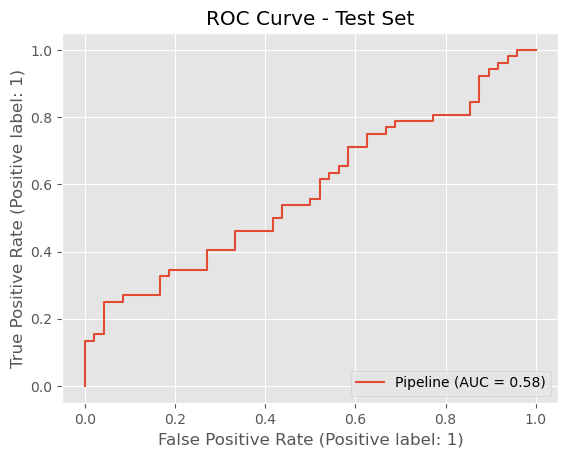

In [23]:
from sklearn.metrics import RocCurveDisplay, ConfusionMatrixDisplay

RocCurveDisplay.from_estimator(pipeline, X_test, y_test)
plt.title("ROC Curve - Test Set")
plt.savefig("../reports/figures/roc_curve_test_set.png")
plt.show()
plt.close()

The ROC curve on the test set shows the model's ability to distinguish between classes (rise vs no rise).
The area under the curve (AUC = 0.58) indicates a modest discriminative capacity: just slightly better than a random classifier (AUC = 0.5).
This reflects that the model does not achieve a clear separation between classes based on the predicted probabilities, although it may still be useful if the decision threshold is adjusted.
Given the low AUC, it is not advisable to use the probability directly for financial decisions, and it is preferable to maintain a discrete approach (binary classification).

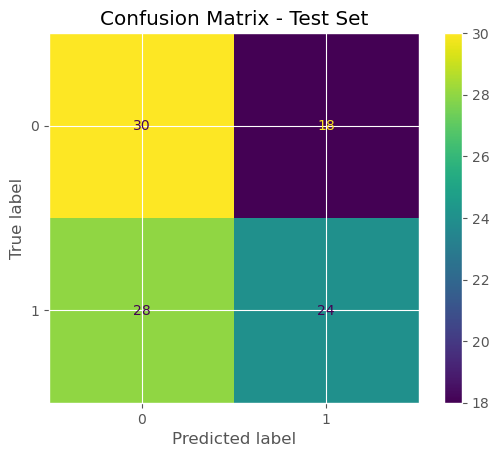

In [24]:
ConfusionMatrixDisplay.from_estimator(pipeline, X_test, y_test)
plt.title("Confusion Matrix - Test Set")
plt.savefig("../reports/figures/confusion_matrix_test_set.png")
plt.show()
plt.close()

The confusion matrix allows us to observe how correct and incorrect predictions are distributed.
The model correctly predicts 30 drops (True Negatives) and 24 rises (True Positives), but it also makes 28 mistakes by predicting a drop when it was actually a rise (False Negatives).
There is a certain bias towards predicting drops (class 0), which is consistent with the difficulty of anticipating positive movements in volatile markets like BTC.
This reinforces the decision to segment the problem and build a specific model to detect rises, and another for drops.